### Import Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = 8, 4

### Read two input data files

In [3]:
master_data = pd.read_csv(r'C:/Users/sayan/Desktop/application_record.csv')
master_record = pd.read_csv(r'C:/Users/sayan/Desktop/credit_record.csv')

In [4]:
application= master_data.copy()
credit = master_record.copy()

## Data Processing

In [5]:
len(set(master_data['ID']))

438510

In [6]:
len(set(master_record['ID']))

45985

In [7]:
len(set(master_data['ID']).intersection(set(master_record['ID'])))

36457

In [8]:
master_record.head(7)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C


In [9]:
application_df = master_data.copy()

Delete duplicate rows


In [10]:
application_df.loc[application_df.DAYS_EMPLOYED==-1194].loc[application_df.DAYS_BIRTH== -10554]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
213,5009031,F,N,Y,0,315000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10554,-1194,1,0,0,0,Accountants,1.0
214,5009032,F,N,Y,0,315000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10554,-1194,1,0,0,0,Accountants,1.0
215,6153669,F,N,Y,0,315000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10554,-1194,1,0,0,0,Accountants,1.0


In [11]:
application_df = application_df.drop_duplicates(subset=application_df.columns[1:], keep='first', inplace=False)
application_df.loc[application_df.DAYS_BIRTH== -10554]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
213,5009031,F,N,Y,0,315000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10554,-1194,1,0,0,0,Accountants,1.0
359960,6491536,F,Y,Y,0,234000.0,Working,Secondary / secondary special,Married,House / apartment,-10554,-1741,1,0,1,0,Waiters/barmen staff,2.0
363841,6508956,M,Y,Y,0,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10554,-534,1,0,0,0,Laborers,1.0
375944,6590652,M,Y,N,0,315000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-10554,-2127,1,0,0,0,Drivers,2.0


In [12]:
len(set(application_df['ID']))

90085

Set X and C in Status column to zero

In [13]:
credit_status = master_record.copy()

# replace X, and C by 0
credit_status.STATUS.replace('X', 0, inplace=True)
credit_status.STATUS.replace('C', 0, inplace=True)
credit_status.STATUS = credit_status.STATUS.astype('int')

# record the worst credit record.
credit_record = credit_status.groupby('ID').STATUS.max()
credit_record.head(10)

# combine two table
df = pd.merge(application_df, credit_record, how='inner', on=['ID'])

Set more than 60 days due (2 or more as status) as rejected (1)

In [14]:
df.STATUS = df.STATUS.apply(lambda x: 1 if x >= 2 else 0)
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,0


In [15]:
df.shape

(9709, 19)

## EDA 1

In [16]:
df = df.sort_values('AMT_INCOME_TOTAL')
df = df.reset_index(drop=True)
df.ID=df.index
df.columns = ('User_id',
              'Gender',
              'Car',
              'Realty',
              'children_count',
              'income_amount',
              'income_type',
              'education_type',
              'Family_status',
              'Housing_type',
              'Days_birth',
              'Days_employed',
              'Mobile',
              'Work_phone',
              'Phone',
              'Email',
              'Occupation_type',
              'Count_family_members',
              'Reject'
              )

In [17]:


print('There are '+str(df.Reject.sum()) +' rejected applicants\n', str(round(df.Reject.sum()/len(df)*100,2)) +'% in 9710 applicants')



There are 206 rejected applicants
 2.12% in 9710 applicants


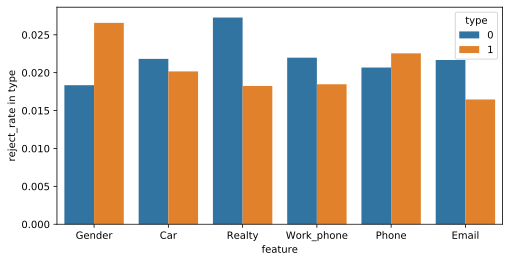

,feature,type,reject_rate in type,count,Reject_count
0,Gender,0,0.018346,6323,116
1,Gender,1,0.026580,3386,90
2,Car,0,0.021828,6139,134
3,Car,1,0.020168,3570,72
4,Realty,0,0.027281,3189,87
5,Realty,1,0.018252,6520,119
6,Work_phone,0,0.021979,7598,167
7,Work_phone,1,0.018475,2111,39
8,Phone,0,0.020677,6916,143
9,Phone,1,0.022556,2793,63


In [18]:
binary_features = ['Gender', 'Car', 'Realty', 'Work_phone', 'Phone', 'Email']
binary_df = df[binary_features+['Reject']].replace('M', 1).replace('F', 0).replace('Y', 1).replace('N', 0)
dict_list = []
for feature in binary_features:
    for one_type in [0, 1]:
        dict_list.append({'feature': feature,
                          'type': one_type,
                          'reject_rate in type': len(binary_df[binary_df[feature]==one_type][binary_df.Reject==1])/len(binary_df[binary_df[feature]==one_type]),
                          'count': len(binary_df[binary_df[feature]==one_type]),
                          'Reject_count': len(binary_df[binary_df[feature]==one_type][binary_df.Reject==1])
                         })

group_binary = pd.DataFrame.from_dict(dict_list)
sns.barplot(x="feature", y="reject_rate in type", hue="type", data=group_binary)
plt.show()
group_binary

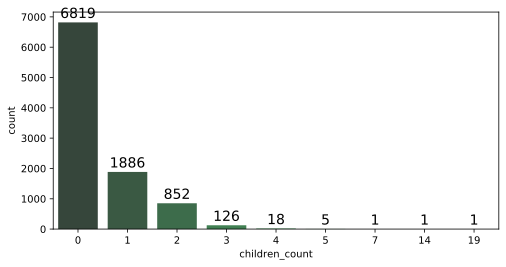

In [19]:
sns.countplot(x="children_count", data=df, palette="Greens_d")
children_count = df.children_count.value_counts()
for a,b in zip(range(len(children_count)), children_count):
    plt.text(a, b+50, '%.0f' % b, ha='center', va= 'bottom',fontsize=14)
plt.show()

In [20]:
children_count_4 = [children_count[0], children_count[1], children_count[2], children_count[3:].sum()]
children_count_4_reject = [len(df[df.children_count==0][df.Reject==1]),
                           len(df[df.children_count==1][df.Reject==1]),
                           len(df[df.children_count==2][df.Reject==1]),
                           len(df[df.children_count>=3][df.Reject==1])]

children_count_df = pd.DataFrame.from_dict({'children_count':children_count_4, 'reject_count':children_count_4_reject})
children_count_df['approved_count'] = children_count_df.children_count - children_count_df.reject_count
children_count_df['reject_rate'] = children_count_df.reject_count/children_count_df.children_count
children_count_df

,children_count,reject_count,approved_count,reject_rate
0,6819,138,6681,0.020238
1,1886,42,1844,0.022269
2,852,20,832,0.023474
3,152,6,146,0.039474


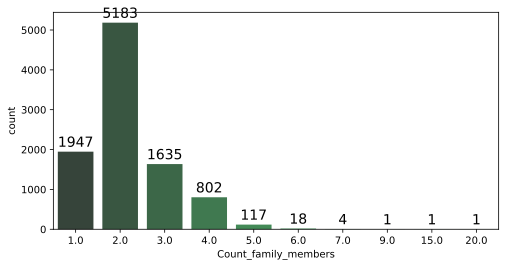

In [21]:
sns.countplot(x="Count_family_members", data=df, palette="Greens_d")
family_members_count = df.Count_family_members.apply(int).value_counts().sort_index()
for a,b in zip(range(len(family_members_count)), family_members_count):
    plt.text(a, b+50, '%.0f' % b, ha='center', va= 'bottom',fontsize=14)
plt.show()

In [22]:
family_members_4 = [family_members_count[1], family_members_count[2], family_members_count[3], family_members_count[4:].sum()]
family_members_4_reject = [len(df[df.Count_family_members==1.0][df.Reject==1]),
                           len(df[df.Count_family_members==2.0][df.Reject==1]),
                           len(df[df.Count_family_members==3.0][df.Reject==1]),
                           len(df[df.Count_family_members>=4.0][df.Reject==1])]

family_members_count_df = pd.DataFrame.from_dict({'family_members_count':family_members_4, 'reject_count':family_members_4_reject})
family_members_count_df['approved_count'] = family_members_count_df.family_members_count - family_members_count_df.reject_count
family_members_count_df['reject_rate'] = family_members_count_df.reject_count/family_members_count_df.family_members_count
family_members_count_df

,family_members_count,reject_count,approved_count,reject_rate
0,1947,47,1900,0.024140
1,5183,104,5079,0.020066
2,1635,34,1601,0.020795
3,142,21,121,0.147887


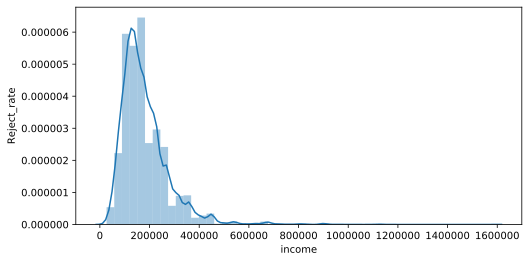

In [23]:
income_plot = pd.Series(df.income_amount, name="income")
plt.ylabel('Reject_rate')
sns.distplot(income_plot)
plt.show()

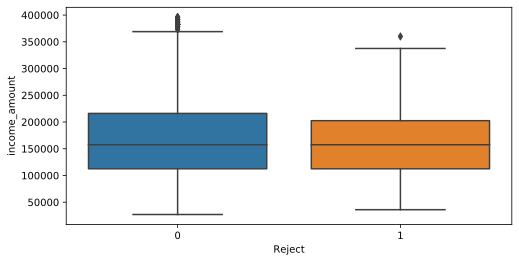

In [24]:


sns.boxplot(x="Reject", y="income_amount", data=df[df.income_amount<=400000])
plt.show()



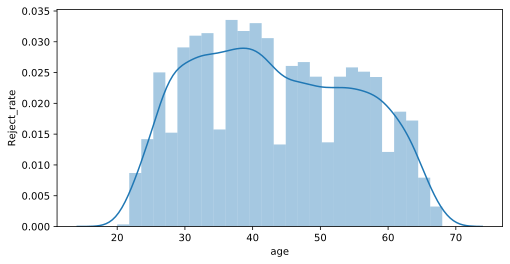

In [25]:
age_series = df.Days_birth.apply(lambda x: int(-x / 365.25))
plt.ylabel('Reject_rate')
age_plot = pd.Series(age_series, name="age")
sns.distplot(age_plot)
plt.show()

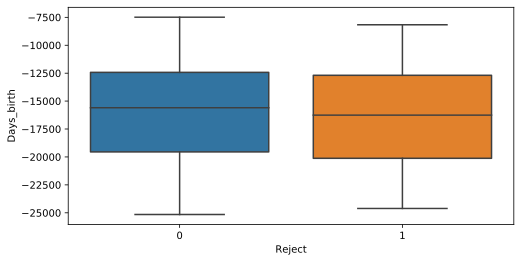

In [26]:


sns.boxplot(x="Reject", y="Days_birth", data=df)
plt.show()



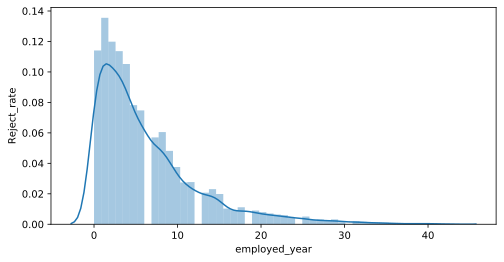

In [27]:
employed_year_series = df[df.Days_employed<0].Days_employed.apply(lambda x: int(-x // 365.25))
plt.ylabel('Reject_rate')
employed_year_plot = pd.Series(employed_year_series, name="employed_year")
sns.distplot(employed_year_plot)
plt.show()

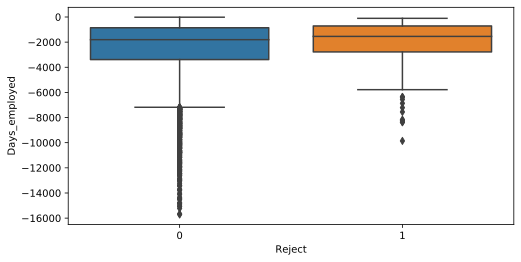

In [28]:
sns.boxplot(x="Reject", y="Days_employed", data=df[df.Days_employed<0])
plt.show()

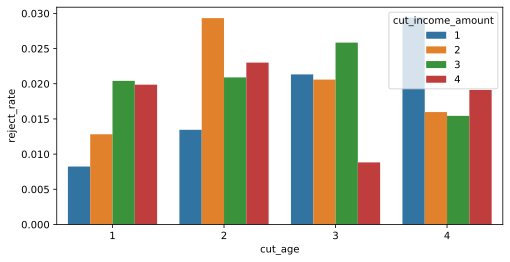

In [29]:
# remove outliers and error rows 
new_df = df[df.income_amount<=400000][df.Days_employed<0]

# transform days to month
new_df['age_month'] = df.Days_birth.apply(lambda x: int(-x / 30.417))
new_df['employed_month'] = df.Days_employed.apply(lambda x: int(-x / 30.417))

# seperate age_month, employed_month, and income
quantile_new_df = new_df[['age_month', 'employed_month', 'income_amount']].quantile([0, 0.25, 0.5, 0.75, 1])
new_df['cut_age'] = pd.cut(new_df['age_month'],bins=quantile_new_df.age_month, right=False, labels=[1, 2, 3, 4])
new_df['cut_employed_month'] = pd.cut(new_df['employed_month'],bins=quantile_new_df.employed_month, right=False, labels=[1, 2, 3, 4])
new_df['cut_income_amount'] = pd.cut(new_df['income_amount'],bins=quantile_new_df.income_amount, right=False, labels=[1, 2, 3, 4])

# group the new_df by age and income
gp_age_income_reject = new_df[new_df.Reject==1].groupby(by=['cut_age','cut_income_amount']).size().reset_index(name='reject_times')
gp_age_income_total = new_df.groupby(by=['cut_age','cut_income_amount']).size().reset_index(name='times')
gp_age_income_reject_rate = pd.merge(gp_age_income_total, gp_age_income_reject, how='outer', on=['cut_age','cut_income_amount'])
gp_age_income_reject_rate['reject_rate'] = gp_age_income_reject_rate.reject_times/gp_age_income_reject_rate.times
sns.barplot(x="cut_age", y="reject_rate", hue="cut_income_amount", data=gp_age_income_reject_rate)
plt.show()

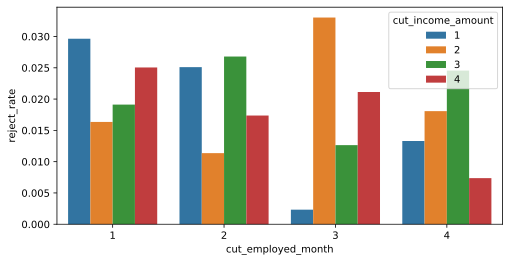

In [30]:
# group the dataset through cut_employed_year and income.
gp_employed_income_reject = new_df[new_df.Reject==1].groupby(by=['cut_employed_month','cut_income_amount']).size().reset_index(name='reject_times')
gp_employed_income_total = new_df.groupby(by=['cut_employed_month','cut_income_amount']).size().reset_index(name='times')
gp_employed_income_reject_rate = pd.merge(gp_employed_income_total, gp_employed_income_reject, how='outer', on=['cut_employed_month','cut_income_amount'])
gp_employed_income_reject_rate['reject_rate'] = gp_employed_income_reject_rate.reject_times/gp_employed_income_reject_rate.times
sns.barplot(x="cut_employed_month", y="reject_rate", hue="cut_income_amount", data=gp_employed_income_reject_rate)
plt.show()

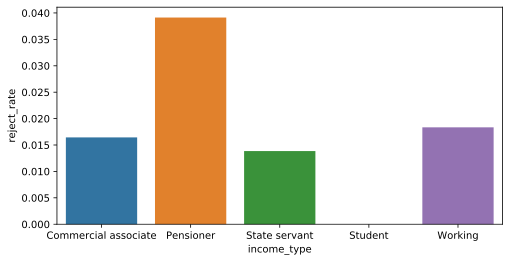

,income_type,times,reject_times,reject_rate
0,Commercial associate,2312,38.0,0.016436
1,Pensioner,1712,67.0,0.039136
2,State servant,722,10.0,0.013850
3,Student,3,0.0,0.000000
4,Working,4960,91.0,0.018347


In [31]:
gp_total=df.groupby(by=['income_type']).size().reset_index(name='times')
gp_reject = df[df.Reject==1].groupby(by=['income_type']).size().reset_index(name='reject_times')
gp_reject_rate = pd.merge(gp_total, gp_reject, how='outer', on=['income_type']).fillna(0)
gp_reject_rate['reject_rate'] = gp_reject_rate.reject_times / gp_reject_rate.times
sns.barplot(x="income_type", y="reject_rate", data=gp_reject_rate)
plt.show()
gp_reject_rate

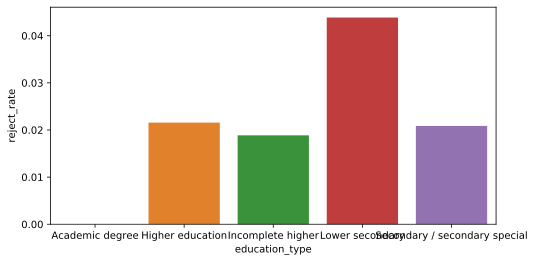

,education_type,times,reject_times,reject_rate
0,Academic degree,6,0.0,0.000000
1,Higher education,2457,53.0,0.021571
2,Incomplete higher,371,7.0,0.018868
3,Lower secondary,114,5.0,0.043860
4,Secondary / secondary special,6761,141.0,0.020855


In [32]:


gp_total=df.groupby(by=['education_type']).size().reset_index(name='times')
gp_reject = df[df.Reject==1].groupby(by=['education_type']).size().reset_index(name='reject_times')
gp_reject_rate = pd.merge(gp_total, gp_reject, how='outer', on=['education_type']).fillna(0)
gp_reject_rate['reject_rate'] = gp_reject_rate.reject_times / gp_reject_rate.times
sns.barplot(x="education_type", y="reject_rate", data=gp_reject_rate)
plt.show()
gp_reject_rate



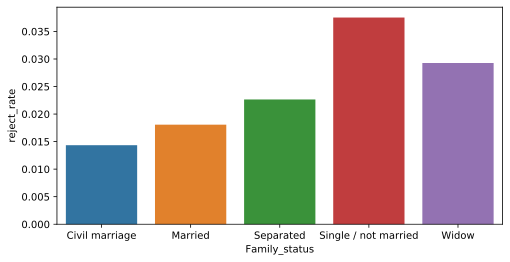

,Family_status,times,reject_times,reject_rate
0,Civil marriage,836,12,0.014354
1,Married,6530,118,0.018070
2,Separated,574,13,0.022648
3,Single / not married,1359,51,0.037528
4,Widow,410,12,0.029268


In [33]:
gp_total=df.groupby(by=['Family_status']).size().reset_index(name='times')
gp_reject = df[df.Reject==1].groupby(by=['Family_status']).size().reset_index(name='reject_times')
gp_reject_rate = pd.merge(gp_total, gp_reject, how='outer', on=['Family_status']).fillna(0)
gp_reject_rate['reject_rate'] = gp_reject_rate.reject_times / gp_reject_rate.times
sns.barplot(x="Family_status", y="reject_rate", data=gp_reject_rate)
plt.show()
gp_reject_rate

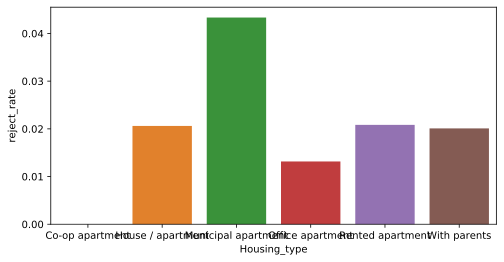

,Housing_type,times,reject_times,reject_rate
0,Co-op apartment,34,0.0,0.000000
1,House / apartment,8684,179.0,0.020613
2,Municipal apartment,323,14.0,0.043344
3,Office apartment,76,1.0,0.013158
4,Rented apartment,144,3.0,0.020833
5,With parents,448,9.0,0.020089


In [34]:
gp_total=df.groupby(by=['Housing_type']).size().reset_index(name='times')
gp_reject = df[df.Reject==1].groupby(by=['Housing_type']).size().reset_index(name='reject_times')
gp_reject_rate = pd.merge(gp_total, gp_reject, how='outer', on=['Housing_type']).fillna(0)
gp_reject_rate['reject_rate'] = gp_reject_rate.reject_times / gp_reject_rate.times
sns.barplot(x="Housing_type", y="reject_rate", data=gp_reject_rate)
plt.show()
gp_reject_rate

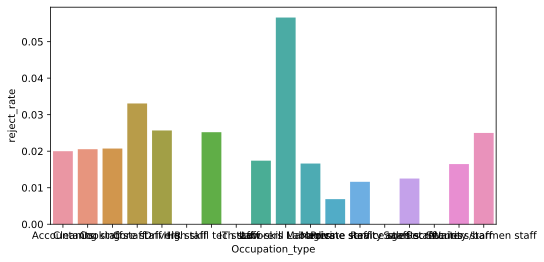

,Occupation_type,times,reject_times,reject_rate
15,Secretaries,46,0.0,0.000000
13,Realty agents,16,0.0,0.000000
5,HR staff,22,0.0,0.000000
7,IT staff,18,0.0,0.000000
11,Medicine staff,291,2.0,0.006873
12,Private service staff,86,1.0,0.011628
14,Sales staff,959,12.0,0.012513
16,Security staff,182,3.0,0.016484
10,Managers,782,13.0,0.016624
8,Laborers,1724,30.0,0.017401


In [35]:
gp_total=df.groupby(by=['Occupation_type']).size().reset_index(name='times')
gp_reject = df[df.Reject==1].groupby(by=['Occupation_type']).size().reset_index(name='reject_times')
gp_reject_rate = pd.merge(gp_total, gp_reject, how='outer', on=['Occupation_type']).fillna(0)
gp_reject_rate['reject_rate'] = gp_reject_rate.reject_times / gp_reject_rate.times
sns.barplot(x="Occupation_type", y="reject_rate", data=gp_reject_rate)
plt.show()
gp_reject_rate.sort_values('reject_rate')

## Vintage Analysis

In [36]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### vintage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [37]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage   

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [38]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


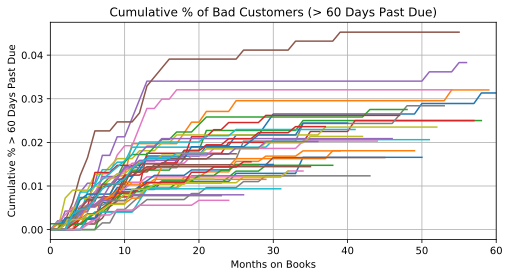

In [39]:
# plot vintage line chart
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

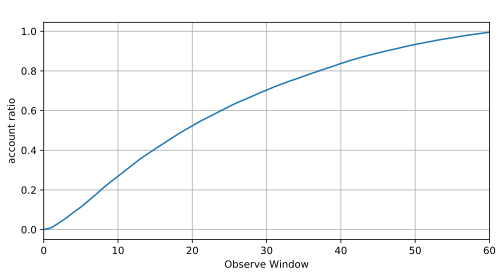

In [40]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [41]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

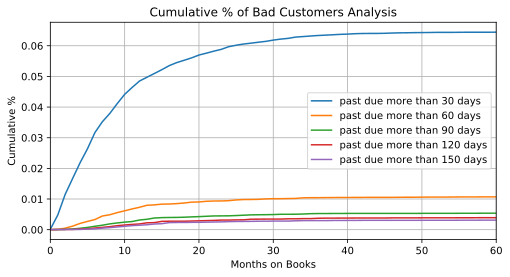

In [42]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })
obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

In [43]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


## WOE and IV

In [44]:
data = application_df.copy()
record = master_record.copy()

In [45]:
application_df.shape

(90085, 18)

In [46]:
master_data.shape

(438557, 18)

In [47]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

In [48]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [49]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [50]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

In [51]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

Drop Null values (in occupation type)

In [52]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [53]:
new_data.isnull().sum(axis = 0)

ID               0
Gender           0
Car              0
Reality          0
ChldNo           0
inc              0
inctp            0
edutp            0
famtp            0
houtp            0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
wkphone          0
phone            0
email            0
occyp            0
famsize          0
begin_month      0
dep_value        0
target           0
dtype: int64

In [54]:
new_data.shape

(6715, 21)

In [55]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [56]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [57]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [58]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    4039
1    2676
Name: Gender, dtype: int64
This variable's IV is: 0.05018700696953858
0    4039
1    2676
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,4039,3974,65,0.601489,0.016093,0.603676,0.492424,0.203697,0.022662
1,Gender,1,2676,2609,67,0.398511,0.025037,0.396324,0.507576,-0.247414,0.027525


In [61]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    3979
1    2736
Name: Car, dtype: int64
This variable's IV is: 1.1653458813685119e-05
0    3979
1    2736
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,3979,3901,78,0.592554,0.019603,0.592587,0.590909,0.002835,0.000005
1,Car,1,2736,2682,54,0.407446,0.019737,0.407413,0.409091,-0.004110,0.000007


In [62]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    4405
0    2310
Name: Reality, dtype: int64
This variable's IV is: 0.023382891648622044
1    4405
0    2310
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,2310,2255,55,0.344006,0.02381,0.342549,0.416667,-0.195872,0.014518
1,Reality,1,4405,4328,77,0.655994,0.01748,0.657451,0.583333,0.119611,0.008865


In [63]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

1    0.286969
0    0.713031
Name: phone, dtype: float64
This variable's IV is: 0.002777013223539536
0    4788
1    1927
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,4788,4697,91,0.713031,0.019006,0.713504,0.689394,0.034376,0.000829
1,phone,1,1927,1886,41,0.286969,0.021277,0.286496,0.310606,-0.080803,0.001948


In [64]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.902904
1    0.097096
Name: email, dtype: float64
This variable's IV is: 0.019327084402352864
0    6063
1     652
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,6063,5939,124,0.902904,0.020452,0.902172,0.939394,-0.040429,0.001505
1,email,1,652,644,8,0.097096,0.012270,0.097828,0.060606,0.478813,0.017822


In [65]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.0014905798324567922
0    4925
1    1790
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,4925,4826,99,0.733433,0.020102,0.7331,0.75,-0.022791,0.000385
1,wkphone,1,1790,1757,33,0.266567,0.018436,0.2669,0.25,0.065412,0.001105


In [66]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        4311
1        1568
2More     836
Name: ChldNo, dtype: int64


In [67]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.019348474852223577
0        4311
1        1568
2More     836
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,4311,4235,76,0.641996,0.017629,0.643324,0.575758,0.110961,0.007497
1,ChldNo,1,1568,1531,37,0.233507,0.023597,0.232569,0.280303,-0.186685,0.008911
2,ChldNo,2More,836,817,19,0.124497,0.022727,0.124108,0.143939,-0.148244,0.002940


In [68]:
new_data = convert_dummy(new_data,'ChldNo')

(2.544, 18.18]      4094
(18.18, 33.66]      2120
(33.66, 49.14]       407
(49.14, 64.62]        43
(64.62, 80.1]         31
(80.1, 95.58]         14
(95.58, 111.06]        1
(111.06, 126.54]       3
(126.54, 142.02]       1
(142.02, 157.5]        1
Name: inc, dtype: int64


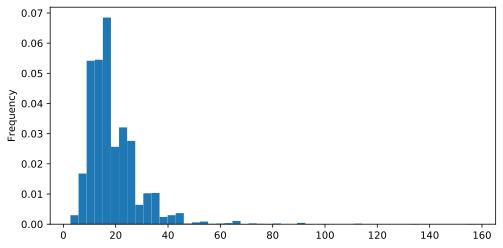

In [69]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [70]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0009123316043345987
low       2536
high      2124
medium    2055
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,2124,2081,43,0.316307,0.020245,0.316117,0.325758,-0.030040,0.000290
1,gp_inc,low,2536,2488,48,0.377662,0.018927,0.377943,0.363636,0.038590,0.000552
2,gp_inc,medium,2055,2014,41,0.306031,0.019951,0.305940,0.310606,-0.015138,0.000071


In [71]:
new_data = convert_dummy(new_data,'gp_inc')

(19.951999999999998, 24.7]    0.033507
(24.7, 29.4]                  0.132539
(29.4, 34.1]                  0.165153
(34.1, 38.8]                  0.137602
(38.8, 43.5]                  0.174088
(43.5, 48.2]                  0.140730
(48.2, 52.9]                  0.097543
(52.9, 57.6]                  0.080566
(57.6, 62.3]                  0.031273
(62.3, 67.0]                  0.006999
Name: Age, dtype: float64


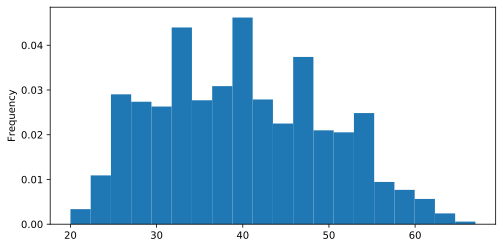

In [72]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [73]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.01992684150813017
medium     2114
low        2033
high       1196
lowest     1115
highest     257
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,1196,1165,31,0.178109,0.025920,0.176971,0.234848,-0.282955,0.016377
1,gp_Age,highest,257,257,0,0.038273,0.000000,0.039040,0.000000,0.000000,0.000000
2,gp_Age,low,2033,1992,41,0.302755,0.020167,0.302598,0.310606,-0.026122,0.000209
3,gp_Age,lowest,1115,1096,19,0.166046,0.017040,0.166489,0.143939,0.145540,0.003282
4,gp_Age,medium,2114,2073,41,0.314818,0.019395,0.314902,0.310606,0.013736,0.000059


In [74]:
new_data = convert_dummy(new_data,'gp_Age')

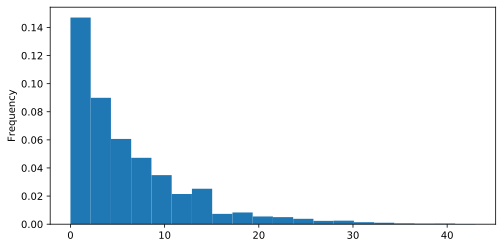

In [75]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [76]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.029143352590809548
lowest     4979
low        1284
medium      326
high        105
highest      21
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,105,104,1,0.015637,0.009524,0.015798,0.007576,0.734947,0.006043
1,gp_worktm,highest,21,21,0,0.003127,0.000000,0.003190,0.000000,0.000000,0.000000
2,gp_worktm,low,1284,1265,19,0.191214,0.014798,0.192162,0.143939,0.288944,0.013934
3,gp_worktm,lowest,4979,4872,107,0.741474,0.021490,0.740088,0.810606,-0.091013,0.006418
4,gp_worktm,medium,326,321,5,0.048548,0.015337,0.048762,0.037879,0.252559,0.002749


In [77]:
new_data = convert_dummy(new_data,'gp_worktm')

In [78]:
new_data['famsize'].value_counts(sort=False)

2.0     3363
1.0     1203
5.0       97
3.0     1363
4.0      670
6.0       13
15.0       1
7.0        3
20.0       1
9.0        1
Name: famsize, dtype: int64

In [79]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.004400012681251231
2        3363
3more    2149
1        1203
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,1203,1177,26,0.179151,0.021613,0.178794,0.196970,-0.096816,0.001760
1,famsizegp,2,3363,3301,62,0.500819,0.018436,0.501443,0.469697,0.065402,0.002076
2,famsizegp,3more,2149,2105,44,0.320030,0.020475,0.319763,0.333333,-0.041563,0.000564


In [80]:
new_data = convert_dummy(new_data,'famsizegp')

In [81]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Pensioner                 12
Commercial associate    1939
Working                 4162
State servant            600
Student                    2
Name: inctp, dtype: int64
Pensioner               0.001787
Commercial associate    0.288757
Working                 0.619806
State servant           0.089352
Student                 0.000298
Name: inctp, dtype: float64
This variable's IV is: 0.05719830148303274
Working                 4162
Commercial associate    1939
State servant            614
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,1939,1907,32,0.288757,0.016503,0.289686,0.242424,0.178107,0.008418
1,inctp,State servant,614,592,22,0.091437,0.035831,0.089929,0.166667,-0.616980,0.047346
2,inctp,Working,4162,4084,78,0.619806,0.018741,0.620386,0.590909,0.048679,0.001435


In [82]:
new_data = convert_dummy(new_data,'inctp')

In [83]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      2961
officewk     2597
hightecwk    1157
Name: occyp, dtype: int64
This variable's IV is: 0.000796473668055383
Laborwk      2961
officewk     2597
hightecwk    1157
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,2961,2901,60,0.440953,0.020263,0.440681,0.454545,-0.030978,0.000430
1,occyp,hightecwk,1157,1135,22,0.172301,0.019015,0.172414,0.166667,0.033902,0.000195
2,occyp,officewk,2597,2547,50,0.386746,0.019253,0.386906,0.378788,0.021205,0.000172


In [84]:
new_data = convert_dummy(new_data,'occyp')

In [85]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.02868352083429697
House / apartment      5922
With parents            362
Municipal apartment     233
Rented apartment        112
Office apartment         58
Co-op apartment          28
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,28,28,0,0.004170,0.000000,0.004253,0.000000,0.000000,0.000000
1,houtp,House / apartment,5922,5811,111,0.881906,0.018744,0.882728,0.840909,0.048534,0.002030
2,houtp,Municipal apartment,233,224,9,0.034698,0.038627,0.034027,0.068182,-0.695022,0.023738
3,houtp,Office apartment,58,57,1,0.008637,0.017241,0.008659,0.007576,0.133607,0.000145
4,houtp,Rented apartment,112,109,3,0.016679,0.026786,0.016558,0.022727,-0.316708,0.001954


In [86]:
new_data = convert_dummy(new_data,'houtp')

In [87]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.022805634843693006
Secondary / secondary special    4598
Higher education                 1792
Incomplete higher                 269
Lower secondary                    56
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,1792,1753,39,0.266865,0.021763,0.266292,0.295455,-0.103922,0.003031
1,edutp,Incomplete higher,269,265,4,0.040060,0.014870,0.040255,0.030303,0.283992,0.002826
2,edutp,Lower secondary,56,53,3,0.008340,0.053571,0.008051,0.022727,-1.037764,0.015230
3,edutp,Secondary / secondary special,4598,4512,86,0.684736,0.018704,0.685402,0.651515,0.050705,0.001718


In [88]:
new_data = convert_dummy(new_data,'edutp')

In [89]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Widow                   0.022636
Single / not married    0.147729
Civil marriage          0.091437
Married                 0.681906
Separated               0.056292
Name: famtp, dtype: float64

In [90]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.15655716904813102
Married                 4579
Single / not married     992
Civil marriage           614
Separated                378
Widow                    152
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,614,606,8,0.091437,0.013029,0.092055,0.060606,0.417995,1.314561e-02
1,famtp,Married,4579,4503,76,0.681906,0.016598,0.684035,0.575758,0.172322,1.865850e-02
2,famtp,Separated,378,373,5,0.056292,0.013228,0.056661,0.037879,0.402697,7.563572e-03
3,famtp,Single / not married,992,952,40,0.147729,0.040323,0.144615,0.303030,-0.739758,1.171891e-01
4,famtp,Widow,152,149,3,0.022636,0.019737,0.022634,0.022727,-0.004110,3.831063e-07


In [91]:
new_data = convert_dummy(new_data,'famtp')

In [92]:
new_data.shape

(6715, 47)

### IV Table

In [93]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
8,famtp,0.156557
6,inctp,0.0571983
1,Gender,0.050187
11,worktmgp,0.0291434
9,houtp,0.0286835
3,Reality,0.0233829
7,edutp,0.0228056
10,agegp,0.0199268
4,ChldNo,0.0193485
15,email,0.0193271


## Algorithms

In [94]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

Smote

In [95]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_sample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [96]:
Y.value_counts()

0    6583
1     132
Name: target, dtype: int64

In [97]:
unique, counts = np.unique(Y_balance, return_counts=True)

print (np.asarray((unique,  counts)).T)

[[   0 6583]
 [   1 6583]]


Train Test Split

In [98]:
X_balance1= preprocessing.StandardScaler().fit(X_balance).transform(X_balance)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_balance1,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

### Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

In [102]:
from sklearn.model_selection import RandomizedSearchCV

C = np.logspace(-3,1,5)
max_iter = [50,80,100,120,150,180,200]
penalty = ['l1','l2']
tol = np.logspace(-8,-3,6)

param = {'C':C,'max_iter':max_iter,'tol':tol,'penalty':penalty}

logReg_cv = RandomizedSearchCV(LogisticRegression(), 
                               param_distributions=param, 
                               n_iter=100, 
                               cv=10, 
                               scoring='accuracy', 
                               verbose=3, n_jobs=-1)

logReg_cv.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.1s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                        'max_iter': [50, 80, 100, 120, 150, 180,
                                                     200],
                                      

In [103]:
logReg_best = logReg_cv.best_estimator_

y_pred = logReg_best.predict(X_test)
logReg_cv.best_params_

{'tol': 0.001, 'penalty': 'l2', 'max_iter': 50, 'C': 0.001}

In [104]:
from sklearn import metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      1975
           1       0.63      0.70      0.66      1975

    accuracy                           0.64      3950
   macro avg       0.64      0.64      0.64      3950
weighted avg       0.64      0.64      0.64      3950



In [105]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.64
Precision: 0.6257389722601182
Recall: 0.6967088607594937


In [106]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1152,  823],
       [ 599, 1376]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

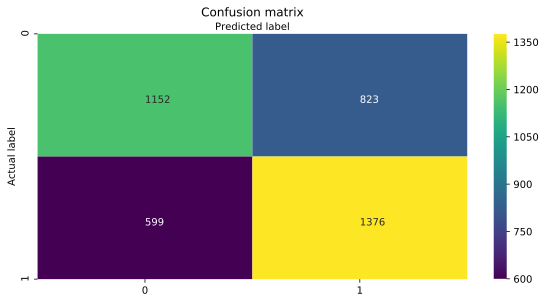

In [107]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

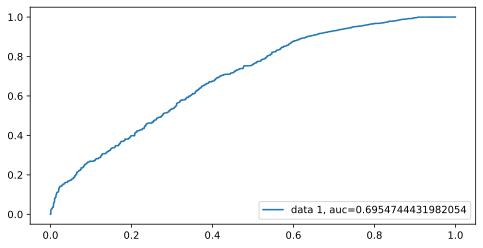

In [108]:
y_pred_proba = logReg_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Decision Tree

In [112]:
from sklearn.model_selection import GridSearchCV
# Create a Parameter grid
param_grid = {
    'max_depth' : range(4,20,4),
    'min_samples_leaf' : range(20,200,20),
    'min_samples_split' : range(8,192,12),
    'criterion' : ['gini','entropy'] 
}

In [113]:
n_folds = 5

dtree = DecisionTreeClassifier()
grid = GridSearchCV(dtree, param_grid, cv = n_folds, n_jobs = -1,return_train_score=True)

In [114]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 20, 4),
                        

In [115]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'min_samples_leaf': 20,
 'min_samples_split': 32}

In [116]:
grid.best_score_

0.9189453125

In [117]:
best_grid = grid.best_estimator_
best_grid

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [118]:
best_grid.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [119]:
best_grid.score(X_test,y_test)

0.9288607594936709

In [120]:
y_pred = best_grid.predict(X_test)

In [121]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9288607594936709
Precision: 0.9664096916299559
Recall: 0.8886075949367088


In [122]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1914,   61],
       [ 220, 1755]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

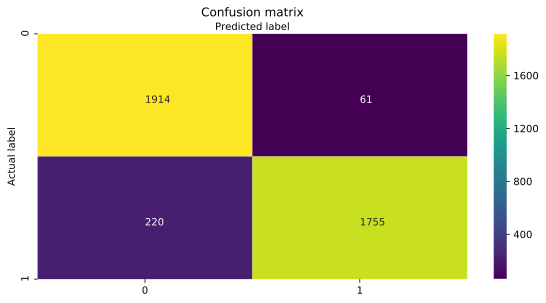

In [123]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Random Forest

In [124]:
rf = RandomForestClassifier()

params = {
                'max_depth' : [3,4,5,6,8,10,12,14,16],
                'min_samples_leaf' : range(8,240,8),
                'max_features' : [0.2,0.4,0.6,0.8],
                'n_estimators' : [150,200,250]
                
        }

rf_cv = RandomizedSearchCV(estimator=rf,
                          param_distributions=params,
                           n_iter=150,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                           verbose=3,
                           random_state=123
                          )

In [125]:
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [126]:
rf_cv.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 8,
 'max_features': 0.4,
 'max_depth': 16}

In [127]:
y_pred = rf_cv.predict(X_test)

In [128]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9746835443037974
Precision: 0.9880270692347736
Recall: 0.9610126582278481


In [129]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1952,   23],
       [  77, 1898]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

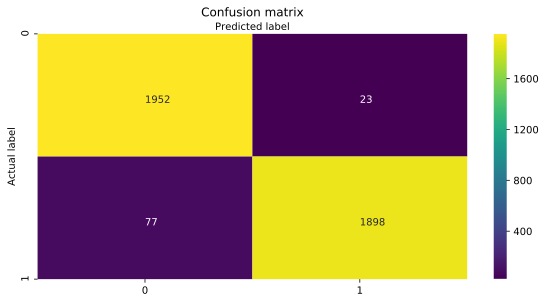

In [130]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Support Vector Classifier

In [135]:
model = svm.SVC(C = 0.8,
                kernel='rbf')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))



Accuracy Score is 0.92987
      0     1
0  1759   216
1    61  1914


In [136]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

Accuracy: 0.929873417721519
Precision: 0.8985915492957747
Recall: 0.9691139240506329


Text(0.5, 257.44, 'Predicted label')

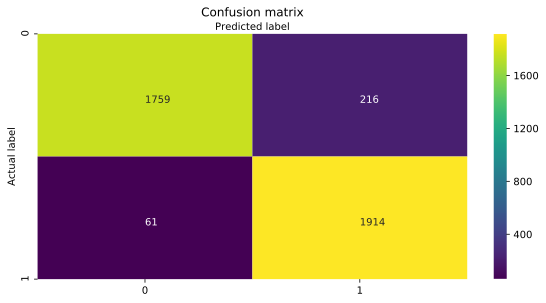

In [137]:
cnf_matrix = confusion_matrix(y_test, y_predict)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Light Gradient Boosting Machine

In [138]:
model = LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy Score is 0.97949
      0     1
0  1968     7
1    74  1901


In [139]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

Accuracy: 0.979493670886076
Precision: 0.9963312368972747
Recall: 0.9625316455696202


Text(0.5, 257.44, 'Predicted label')

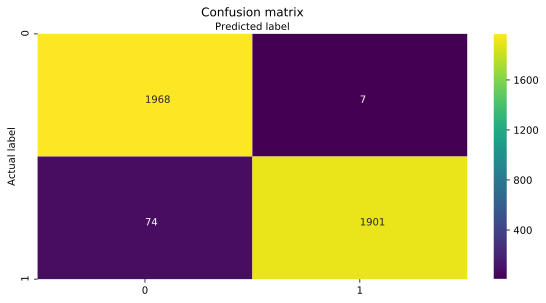

In [140]:
cnf_matrix = confusion_matrix(y_test, y_predict)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### XG Boost

In [141]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



params_xgb = {
                'max_depth' : [3,4,5,6,8,12,14],
                'min_samples_leaf' : [0.02,0.04,0.05,0.06],
                'max_features' : [0.2,0.4,0.6,0.8,0.9],
                'n_estimators' : [150,200,250],
                'subsample' : np.arange(0.05,1.05,0.1),
                'learning_rate' : np.arange(0.05,1.05,0.1),
                'colsample_bytree' : np.arange(0.05,1.05,0.1),
                'gamma' : [0.05,0.1,0.5,1]
                           
            }

gbm = xgb.XGBClassifier()

xgb_cv =     RandomizedSearchCV(estimator=gbm,
                                n_iter=150,
                                param_distributions=params_xgb, 
                                cv=5, scoring='accuracy',
                                n_jobs=-1, verbose=2,
                               random_state=123)

In [142]:
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                        'learning_rate': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
                                        'max_depth': [3, 4, 5, 6, 8, 12, 14],
                  

In [143]:
xgb_cv.best_params_

{'subsample': 0.7500000000000002,
 'n_estimators': 250,
 'min_samples_leaf': 0.04,
 'max_features': 0.8,
 'max_depth': 4,
 'learning_rate': 0.25000000000000006,
 'gamma': 0.1,
 'colsample_bytree': 0.45000000000000007}

In [144]:
y_pred = xgb_cv.predict(X_test)

In [145]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.980253164556962
Precision: 0.9968569931901519
Recall: 0.9635443037974684


In [146]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1969,    6],
       [  72, 1903]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

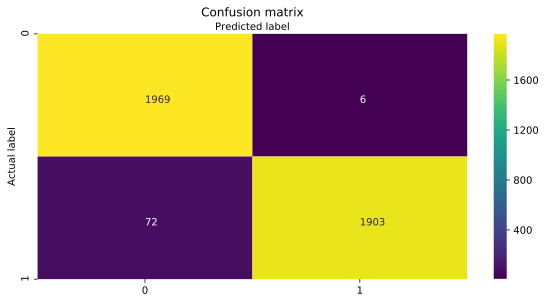

In [147]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Gradient Boosting Classifier

In [150]:
from sklearn.ensemble import GradientBoostingClassifier

In [151]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2,.5,1],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[1,3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,50,100,150]
    }
#passing the scoring function in the GridSearchCV
#clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1, verbose = 2, random_state=123)
clf = RandomizedSearchCV(GradientBoostingClassifier(),
                          param_distributions=parameters,
                           n_iter=150,
                          cv=5,
                          scoring='accuracy',
                         refit=True,
                          n_jobs=-1,
                           verbose=3,
                           random_state=123
                          )

In [152]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 607 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [153]:
clf.best_params_


{'subsample': 0.95,
 'n_estimators': 150,
 'min_samples_split': 0.46363636363636374,
 'min_samples_leaf': 0.13636363636363638,
 'max_features': 'sqrt',
 'max_depth': 5,
 'loss': 'deviance',
 'learning_rate': 1,
 'criterion': 'friedman_mse'}

In [154]:
clf.best_score_

0.9572482638888888

In [155]:

y_pred = clf.predict(X_test)

In [156]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9559493670886076
Precision: 0.9928845101258894
Recall: 0.9184810126582279


In [157]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1962,   13],
       [ 161, 1814]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

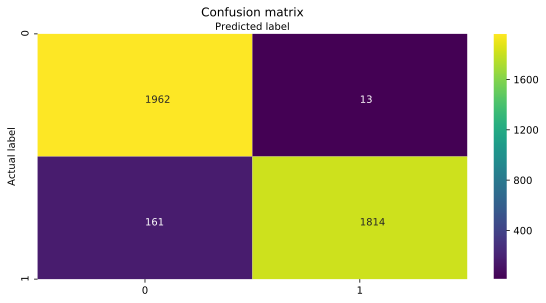

In [158]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [160]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

In [161]:
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')

In [162]:
grid_ABC.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                   

In [163]:
grid_ABC.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'n_estimators': 2}

In [164]:
grid_ABC.best_score_

0.9857313368055556

In [165]:
grid_ABC.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                   

In [166]:
grid_ABC.score(X_test,y_test)

0.9877642685467072

In [167]:
y_pred = grid_ABC.predict(X_test)

In [168]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9759493670886076
Precision: 0.9885654885654885
Recall: 0.9630379746835444


In [169]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1953,   22],
       [  73, 1902]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

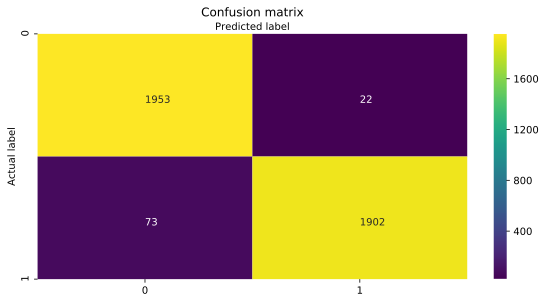

In [170]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Naive Bayes

In [171]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.52835
     0     1
0  133  1842
1   21  1954


In [172]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

Accuracy: 0.5283544303797468
Precision: 0.5147523709167545
Recall: 0.9893670886075949


### Stochastic Gradient Descent

In [173]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(max_iter=1000, tol=1e-3)
#model = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.61089
      0     1
0  1352   623
1   914  1061


In [174]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

Accuracy: 0.6108860759493671
Precision: 0.6300475059382423
Recall: 0.5372151898734178


### Cat Boost

In [175]:
model = CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

0:	learn: 0.5015227	total: 2.86s	remaining: 11m 52s
25:	learn: 0.0566764	total: 1m 4s	remaining: 9m 16s
50:	learn: 0.0412336	total: 2m 5s	remaining: 8m 9s
75:	learn: 0.0342407	total: 3m 4s	remaining: 7m 1s
100:	learn: 0.0311673	total: 4m 1s	remaining: 5m 56s
125:	learn: 0.0298823	total: 4m 59s	remaining: 4m 55s
150:	learn: 0.0290828	total: 5m 59s	remaining: 3m 55s
175:	learn: 0.0286675	total: 6m 59s	remaining: 2m 56s
200:	learn: 0.0286495	total: 7m 56s	remaining: 1m 56s
225:	learn: 0.0286276	total: 8m 56s	remaining: 56.9s
249:	learn: 0.0285597	total: 9m 50s	remaining: 0us
CatBoost Accuracy Score is 0.98253
      0     1
0  1958    17
1    52  1923


In [176]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

Accuracy: 0.9825316455696202
Precision: 0.9912371134020619
Recall: 0.9736708860759493


In [177]:
cnf_matrix = confusion_matrix(y_test, y_predict)
cnf_matrix

array([[1958,   17],
       [  52, 1923]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

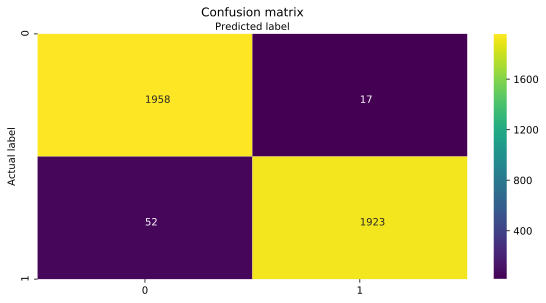

In [178]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
annot_kws = {"ha": 'left',"va": 'top'}
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,annot_kws=annot_kws, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[.5, 1.5], 
       )
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')